In [29]:
# Imports
import gym
import QDgym_extended
import numpy as np
import scipy.ndimage as ndimage
from modifier import modify
import math


def decode_genotype(genotype):
    """genotype: shape (24,) array, 3 parameters for each of the 8 motors.
    each motor genotype in the form of (duty_cycle, phase, scale).

    duty_cycle : [0, 1)
    phase: [0, 1)
    scale: [0, 1]
    """
    
    targets = -np.ones((100, 8), dtype=np.float32)
    phase = np.int32(genotype[1::3] * 100)
    for index, duty_cycle in enumerate(genotype[0::3]):
        start = phase[index]
        end = int(duty_cycle*101) + start
        targets[start: end, index] = 1
        if end > 100:
            targets[: end-100, index] = 1

    guassian_kernel = np.array([0.0008880585, 0.0015861066, 0.00272177, 0.00448744, 0.007108437, 0.010818767, 
                                0.015820118, 0.022226436, 0.03000255, 0.03891121, 0.048486352, 0.058048703, 
                                0.0667719, 0.073794365, 0.078357555, 0.07994048, 0.078357555, 0.073794365, 
                                0.0667719, 0.058048703, 0.048486352, 0.03891121, 0.03000255, 0.022226436, 
                                0.015820118, 0.010818767, 0.007108437, 0.00448744, 0.00272177, 0.0015861066, 
                                0.0008880585], dtype=np.float32)

    targets = ndimage.convolve1d(targets, guassian_kernel, axis=0, mode="wrap")
    
    scales = np.float32(genotype[2::3])
    return targets, scales


In [48]:
# Make environment
# env = gym.make("QDDeterministicWalker2DBulletEnv-v0")
# env = gym.make("QDAntOmnidirectionalBulletEnv-v0")

modify(10, 1.0)
env = gym.make("QDCustomAntBulletEnv-v0", robot_file="custom_ant.xml")

# Reset environment

state = env.reset()
done = False

n = 0

# genotype = np.ones(24)
# genotype[1::3] = 0
# genotype[0::3] = 0.7

genotype = np.random.uniform(0, 1, (24))
genotype = np.array([0.259303, 0.635747, 0.798838, 0.734469, 
                     0.777344, 0.042424, 0.250724, 0.482677, 
                     0.862689, 0.476355, 0.0, 0.478584, 
                     0.631273, 0.484417, 0.735959, 0.311633, 
                     0.834801, 0.807166, 0.43869, 0.129341, 
                     0.106889, 0.217222, 0.810687, 0.548715])

# genotype = np.array([0.5968, 0.725634, 0.9999, 0.31895, 
#                      0.156913, 0.357329, 0.744598, 0.168164, 
#                      0.016688, 0.598645, 0.225869, 0.70942, 
#                      0.661377, 0.307844, 0.778356, 0.734412, 
#                      0.628775, 0.103119, 0.75821, 0.801563, 
#                      0.140996, 0.538683, 0.261772, 0.493624])

targets, scales = decode_genotype(genotype)



kds = np.array([0.072, 0.082, 0.072, 0.082, 0.072, 0.082, 0.072, 0.082], dtype=np.float32)
kps = np.array([1.43, 1.637, 1.43, 1.637, 1.43, 1.637, 1.43, 1.637], dtype=np.float32)
constants = np.array([0.0, 1.857176, 0.0, -1.857176, 0.0, -1.857176, 0.0, 1.857176], dtype=np.float32)

positions = np.zeros(8, dtype=np.float32)
speeds = np.zeros(8, dtype=np.float32)
for index, joint in enumerate(env.ordered_joints):
    positions[index], speeds[index] = joint.current_position()

# calculate offset
# offset = np.argmin(np.sum(np.square(constants + scales*targets - positions*kps), axis=1))
# print("offset", offset)

xy = np.zeros((1000, 2))

# Evaluation loop
# while not done:
for i in range(1000):
    # target = targets[(n + offset)% 100]
    target = targets[n % 100]
    for index, joint in enumerate(env.ordered_joints):
        positions[index], speeds[index] = joint.current_position()

    # target[1] = -1
    # target[3] = 1
    # target[5] = 1
    # target[7] = -1

    # target[1] = 0.9
    # target[3] = -0.9
    # target[5] = -0.9
    # target[7] = 0.9
    # target[: : 2] = 1
    action = np.clip(constants + scales*target - positions*kps - kds*speeds, -1, 1)

    if not done:
        action[:6] = 0
    # action[:2] = 0
    # action[6] = 0
    # action = np.zeros(8)

    # state, reward, done, info = env.step(action * np.random.uniform(0.8, 1.0, 8))
    state, reward, done, info = env.step(action)

    x, y, z = env.robot_body.pose().xyz()
    xy[n, 0] = x
    xy[n, 1] = y

    n += 1
    if n == 420:
        print(done)
        break

    

# print("attr:", (env._render_width, env._render_height))

# print("step length:", n)

# Get final fitness and BD
fitness = env.tot_reward
behaviour_descriptor = env.desc # alternatively behaviour_descriptor = info["bc"] for compatability with the code released for MAP-Elites-ES


# Close environment
print("length:", n)

argv[0]=
argv[0]=
False
length: 420


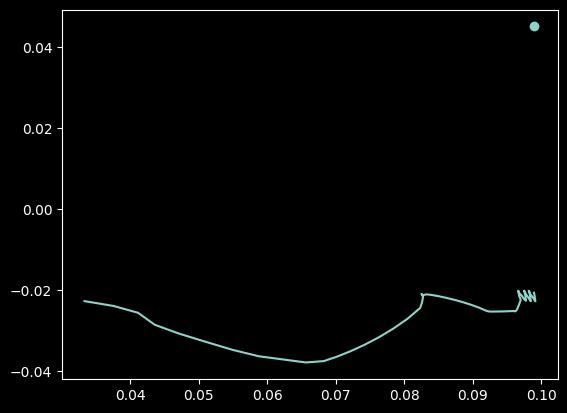

254.6947418622566
0.0989 -0.0206 0.3617
distance: 0.1011


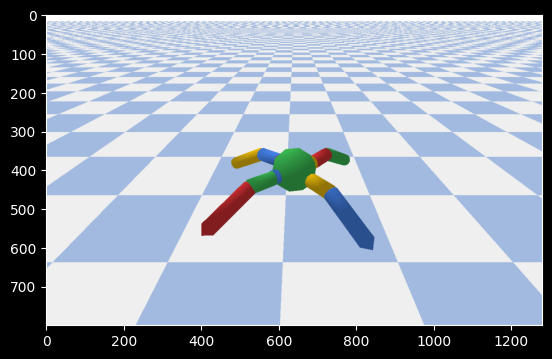

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

x_, y_ = xy[20:n].T
# plt.scatter(x_, y_)
plt.plot(x_, y_)
x_span = np.max(x_) - np.min(x_)
y_span = np.max(y_) - np.min(y_)
if x_span > y_span:
    x_ref = np.max(x)
    y_ref = np.min(y) + x_span
else:
    y_ref = np.max(y)
    x_ref = np.min(x) + y_span
plt.scatter(x_ref, y_ref)
plt.show()

x, y, z = env.robot_body.pose().xyz()
print(fitness)
print(round(x, 4), round(y, 4), round(z, 4))
print("distance:", round(np.sqrt(x**2 + y**2), 4))

image = env.render(mode="rgb_array")
plt.imshow(image)
# plt.savefig("image.png", dpi=500)
plt.show()
env.close()


In [4]:
from trajectory import calculate_arc


In [47]:
# x0, y0 = xy[20, :]
x, y = xy[:n, :].T
# x -= x0
# y -= y0
t = np.linspace(0, 4, n)

v, w, phi = calculate_arc(x, y, t)

final_theta = w*4
R = v / w
x_final = R * (math.sin(final_theta + phi) - math.sin(phi))
y_final = R * (math.cos(phi) - math.cos(final_theta + phi))


print(v)
print(w*57.3)
print(phi*57.3)

final_xy = np.array([x_final, y_final])
print(final_xy)
print("dis", math.sqrt(np.sum((final_xy - xy[n-1])**2)))
print(xy[n-1])


# plt.plot(t, np.sqrt(x**2 + y**2))
# plt.show()

# plt.plot(t, np.sqrt(x**2 + y**2))
# plt.plot(t, 2*v/w*np.sin(0.5*w*t))
# plt.show()

1.2863606760012496
12.3630116187696
-112.48093050404268
[ 0.19593332 -4.98338513]
dis 0.02504465475117527
[ 0.21533183 -4.99922598]


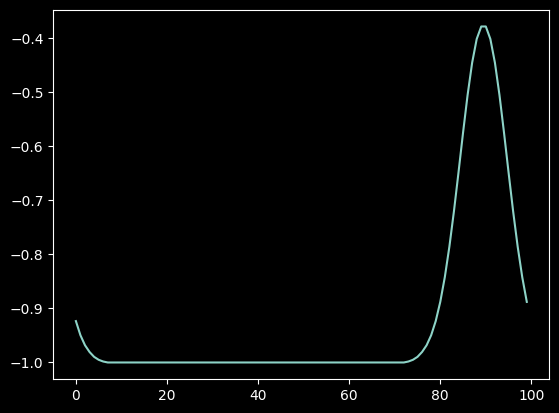

[0.17460326 0.2183581  0.40390352 0.99799454 0.69616055 0.46922313
 0.46020182 0.1319364 ]
[0.04498123 0.88796672 0.17460326]


In [33]:

targets, _ = decode_genotype(genotype)
plt.plot(np.arange(100), targets[:, 0])
plt.show()
print(_)
print(genotype[:3])

In [55]:
guassian_kernel = np.linspace(-3, 3, 31)
guassian_kernel = np.exp(-0.5*np.square(guassian_kernel))
guassian_kernel /= np.sum(guassian_kernel)

# for index, i in enumerate(np.float32(guassian_kernel)):
#     print(i, end=", ")
#     if (index + 1) % 6 == 0:
#         print()

a = np.zeros(8)
b = np.zeros(8)
a[0], b[7] = (2, 5.6)
print(a)
print(b)


[2. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.  0.  0.  0.  0.  5.6]


In [40]:
joints_dict = {0: (0, 0.7, 1.43, 0.18), 1: (1.1345, 0.611, 1.637, 0.205), 
               2: (0, 0.7, 1.43, 0.18), 3: (-1.1345, 0.611, 1.637, 0.205), 
               4: (0, 0.7, 1.43, 0.18), 5: (-1.1345, 0.611, 1.637, 0.205),
               6: (0, 0.7, 1.43, 0.18), 7: (1.1345, 0.611, 1.637, 0.205)}


kds = np.zeros(8)
kps = np.zeros(8)
target_coef = np.zeros(8)
constants = np.zeros(8)

for index in range(8):
    center, scale, kp, kd = joints_dict[index]
    kds[index] = kd* 0.4
    kps[index] = kp 
    target_coef[index] = kp*scale
    constants[index] = center*kp

In [41]:
for index, i in enumerate(constants):
    print(round(i, 6), end=", ")

0.0, 1.857176, 0.0, -1.857176, 0.0, -1.857176, 0.0, 1.857176, 